In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from skorch.regressor import NeuralNetRegressor
from tabularasa.SimultaneousQuantileRegressor import SimultaneousQuantileRegressor, SimultaneousQuantileMixedMonotonicNet
from tabularasa.OrthonormalCertificates import OrthonormalCertificates

In [2]:
df = pd.read_pickle('./examples/data/simple_train.pkl')

In [3]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(1 + 16, 16)
    
    def forward(self, X_non_monotonic):
        X = torch.cat([X_non_monotonic[:, 1, None].float(), 
                       self.emb1(X_non_monotonic[:, 0, None].long()).squeeze()], 1)
        return F.relu(self.fc1(X))

In [4]:
model = SimultaneousQuantileRegressor(SimultaneousQuantileMixedMonotonicNet,
                           max_epochs=25,
                           lr=0.001,
                           optimizer=torch.optim.Adam,
                           module__non_monotonic_net=EmbeddingNet(),
                           module__dim_non_monotonic=16,
                           module__dim_monotonic=2,
                           module__layers=[128, 128, 32],
                           module__integration_steps=300)

In [5]:
model.fit({'X_monotonic': df[['x1', 'x2']].values,
           'X_non_monotonic': df[['x3', 'x4']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        1.9275        0.9001  11.4523
      2        0.5205        0.2456  9.6870
      3        0.2131        0.2201  9.5791
      4        0.2244        0.1963  9.5971
      5        0.1991        0.1971  9.6754
      6        0.1945        0.1972  9.6466
      7        0.1911        0.1976  9.6617
      8        0.1859        0.1920  9.6239
      9        0.1817        0.2038  9.5965
     10        0.1883        0.1766  9.6544
     11        0.1932        0.1851  9.5990
     12        0.1768        0.1813  9.5766
     13        0.1705        0.1746  9.6528
     14        0.1735        0.1742  9.7827
     15        0.1641        0.1632  9.6343
     16        0.1622        0.1599  9.8506
     17        0.1494        0.1429  9.8641
     18        0.1435        0.1468  9.7757
     19        0.1442        0.1453  9.6352
     20        0.1393        0.1403  9.5588
     21        0.1289        

<class 'tabularasa.SimultaneousQuantileRegressor.SimultaneousQuantileRegressor'>[initialized](
  module_=SimultaneousQuantileMixedMonotonicNet(
    (non_monotonic_net): EmbeddingNet(
      (emb1): Embedding(50, 16)
      (fc1): Linear(in_features=17, out_features=16, bias=True)
    )
    (umnn): SlowDMonotonicNN(
      (outer_net): MonotonicNN(
        (integrand): IntegrandNN(
          (inner_net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
          )
          (net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
       

In [6]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [7]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                       'X_non_monotonic': dfc[['x3', 'x4']].values})
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

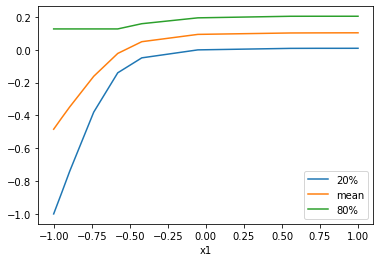

In [8]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

In [9]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values})

array([[-0.8766686 ],
       [ 0.00905031],
       [ 0.01533097],
       ...,
       [ 0.1513311 ],
       [ 0.15269926],
       [ 0.04179281]], dtype=float32)

In [10]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.5)

array([[-0.8766686 ],
       [ 0.00905031],
       [ 0.01533097],
       ...,
       [ 0.1513311 ],
       [ 0.15269926],
       [ 0.04179281]], dtype=float32)

In [11]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.9)

array([[-0.14030454],
       [ 0.00905305],
       [ 0.01533782],
       ...,
       [ 0.15134498],
       [ 0.15270296],
       [ 0.04180634]], dtype=float32)

In [12]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.1)

array([[-1.9311209 ],
       [ 0.00905335],
       [ 0.01534194],
       ...,
       [ 0.15133628],
       [ 0.15270439],
       [ 0.04179388]], dtype=float32)

### Estimate epistemic uncertainty via orthonormal certificates

Start by prepping data from the inner hidden layer.

In [9]:
model.module_.set_last_layer(inner=True)

In [21]:
X_inner = model.predict({'X_monotonic': df[['x1', 'x2']].values,
                         'X_non_monotonic': df[['x3', 'x4']].values})

Now train orthonormal certificates.  Note, including raw numeric features helps quality.

In [24]:
oc = OrthonormalCertificates()
oc.fit(np.concatenate([df[['x1', 'x2', 'x4']].values, X_inner], axis=1))

Create another PDP like dataset with the full range.

In [31]:
uncertainties = []
for q in np.linspace(-1.5, 1.5, 101):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = oc.transform(np.concatenate([dfc[['x1', 'x2', 'x4']],
                                     model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                                                    'X_non_monotonic': dfc[['x3', 'x4']].values})], axis=1))
    p = pd.DataFrame(pd.Series(p).describe(percentiles=quantiles)).T
    p['x1'] = q
    uncertainties.append(p)
uncertainties = pd.concat(uncertainties, axis=0)

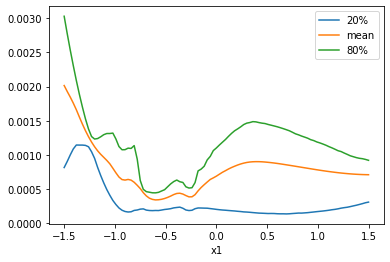

In [32]:
uncertainties.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

Epistemic uncertainty is high below -1 (where training data starts and is relatively low), decreases between -1 and 0, picks back up between 0 and 0.5, and then decreases between 0.5 and 1.  After 1, it doesn't perform exactly as desired, but is ticking up in some places.